In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(Time_matrix.shape)
print(Time_matrix[3][2][17][5])

(5, 5, 24, 7)
8.0


It means the time required to travel from city 3 to city 2 at 17 hrs and 5th day of the week is 8 time units

In [4]:
print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())

Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


### Checking if the environment is responding


In [5]:
from Env import CabDriver 
print("Random State Initialization:")
for i in range(5):         ## Checking for 5 epsiodes
    env= CabDriver()
    random_state_init= env.state_init
    print(f'Episode {i}', random_state_init)

Random State Initialization:
Episode 0 (1, 1, 2)
Episode 1 (2, 4, 2)
Episode 2 (2, 13, 1)
Episode 3 (1, 18, 2)
Episode 4 (2, 10, 4)


In episode 0, the cab is in 2nd city at 8 hrs and 6th day of week

### Checking the action space

In [6]:
## Creating tuples of action_index and actions from action_space
from Env import CabDriver
env= CabDriver()
cab_action_space = env.action_space
cab_action_indices =[i for i in range(len(cab_action_space))]
action_list= [i for i in zip(cab_action_indices, cab_action_space)]   ## tuples (action_indices, action)
print("List of all possible actions")
action_list

List of all possible actions


[(0, (0, 0)),
 (1, (0, 1)),
 (2, (0, 2)),
 (3, (0, 3)),
 (4, (0, 4)),
 (5, (1, 0)),
 (6, (1, 2)),
 (7, (1, 3)),
 (8, (1, 4)),
 (9, (2, 0)),
 (10, (2, 1)),
 (11, (2, 3)),
 (12, (2, 4)),
 (13, (3, 0)),
 (14, (3, 1)),
 (15, (3, 2)),
 (16, (3, 4)),
 (17, (4, 0)),
 (18, (4, 1)),
 (19, (4, 2)),
 (20, (4, 3))]

Since we are doing Q-learning, the network will learn a deterministric policy. Given a state, there is only one favourable action

### Creating the agent who will experience things

In [7]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, 
                 discount_factor=0.95, learning_rate=0.01,
                 epsilon=1, epsilon_decay=0.99, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.batch_size = 32        
        
        # Create replay memory using deque
        self.memory = deque(maxlen = 3000)
        
        # Initialize the value of the states tracked for all samples
        self.states_tracked = []
        
        # Initializing a tracker to check learning
        # We will track state (2,8,6) and action (2,3) during training
        self.track_state = np.array(env.state_encod_arch((2,8,6))).reshape(1, self.state_size)
        
        # Create main model and target model
        self.model = self.build_model()

        
    def build_model(self):
        """
        Takes in the agent and constructs a neural network to train it and returns model and parameters.
        """
        model = Sequential()
        model.add(Dense(32, input_dim= self.state_size, activation= 'relu'))
        model.add(Dense(32, activation= 'relu'))
        model.add(Dense(self.action_size, activation='relu'))
        
        # Compile Model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        return model
    
    def get_action(self, state):
        
        '''
        Choose an action from action space using epsilon greedy policy
        Decay in ε after we generate each sample during an episode
        '''
        possible_actions_index, actions= env.requests(state)
        
        # get action from model using epsilon-greedy policy
        z = np.random.rand()  ## variable z randomly chooses a value between [0,1)
        if z <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = np.array(env.state_encod_arch(state)).reshape(1, self.state_size)
            q_vals = self.model.predict(state)
            q_vals_possible = np.array([q_vals[0][i] for i in possible_actions_index])
            
            ## Choosing the action corresponding to highest q-value
            return possible_actions_index[np.argmax(q_vals_possible)] 
        
    def append_sample(self, state, action_index, reward, next_state, done):
        '''
        Append the new agent run output to replay buffer
        '''
        self.memory.append((state, action_index, reward, next_state, done))
        
    
    def train_model(self):
        """ 
        Function to train the model on each step run.
        Pick random memory events according to batch size and 
        runs it through the network to train it.
        """
      
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            
            ## Initializing the trackers
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch(next_state)
                done.append(done_boolean)
                
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:      #terminal state
                    target[i][actions[i]] = rewards[i]
                else:            # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
             
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    
    def save_tracking_states(self):
        '''
        Use the model to predict the q_value of the state we are tacking.
        '''
        q_value_1 = self.model.predict(self.track_state)
        self.states_tracked.append(q_value_1[0][11])    ## action (2,3) at index 11 in the action space
        
        
    def save_model_weights(self, name): ## Saves the weights in Keras format
        self.model.save_weights(name)
        
        
    def save_weights_numpy(self, name):      ## Saves the 'model_weights' in a  pickle file
        weights= self.model.get_weights()   ## Gets model_weights as a list of numpy arrays
        try:
            fpkl= open(name, 'wb')
            pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)  
            fpkl.close()
        except Exception as e:
            print(e)
            
    def save(self, name):  ## Saves the model in H5 format
        self.model.save(name) 
        

### Preparing training

In [11]:
episode_time = 24*30   
Episodes = 1000       
m = 5                  
t = 24                 
d = 7                  

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class (Parameters kept same as lectures and no tuning is done)
agent = DQNAgent(action_size=action_size, 
                 state_size=state_size,
                 discount_factor=0.95, 
                 learning_rate=0.01,
                 epsilon=1, 
                 epsilon_decay=0.99, 
                 epsilon_min=0.01)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state
rewards_init_state = []

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training Loop

In [12]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):
    print('Episode ', episode)

    done = False
    score = 0

    # Reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # State Initialization 
    initial_state = state


    total_time = 0  # Total time driver rode in this episode
    while done!= True:
        # 1. Pick epsilon-greedy action from possible actions for the current state.
        action= agent.get_action(state)
        
        # 2. Evaluate reward and next state
        next_state, reward, step_time = env.step(state, env.action_space[action], Time_matrix)
        
        # 3. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            done = True
        else:
            # 4. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)   ## Note: Here action is action index
            
            # 5. Train the model by calling function agent.train_model
            agent.train_model()
            
            # 6. Keep a track of rewards, Q-values, loss, etc (Note: Loss is taken care of in the model loss='mse')
            score += reward
            state = next_state

    # Store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay


    # Every 1000 episodes we will print:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, initial_state {1}, reward {2}, memory_length {3}, epsilon {4} total_time {5}".format(episode, 
                                                                         initial_state,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    
    # Save the Q_value of the state-action pair we are tracking (every 10 episodes)
    if ((episode + 1) % 10 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    ## Saving the 'model_weights' every 1000th episode.
    if(episode % 500 == 0):
        print("Saving Episode {} Weights".format(episode))
#         agent.save_model_weights(name="model_weights")  
        agent.save_weights_numpy(name = f'model_weights_{episode}.pkl')
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Episode  0
Saving Episode 0 Weights
Episode  1
Episode  2
Episode  3
Episode  4
Episode  5
Episode  6
Episode  7
Episode  8
Episode  9
episode 9, initial_state (4, 3, 5), reward -31.0, memory_length 1165, epsilon 0.9043820750088043 total_time 722.0
Episode  10
Episode  11
Episode  12
Episode  13
Episode  14
Episode  15
Episode  16
Episode  17
Episode  18
Episode  19
episode 19, initial_state (1, 14, 3), reward 387.0, memory_length 2322, epsilon 0.8179069375972307 total_time 724.0
Episode  20
Episode  21
Episode  22
Episode  23
Episode  24
Episode  25
Episode  26
Episode  27
Episode  28
Episode  29
episode 29, initial_state (2, 20, 1), reward 95.0, memory_length 3000, epsilon 0.7397003733882802 total_time 728.0
Episode  30
Episode  31
Episode  32
Episode  33
Episode  34
Episode  35
Episode  36
Episode  37
Episode  38
Episode  39
episode 39, initial_state (1, 17, 4), reward 321.0, memory_length 3000, epsilon 0.6689717585696803 total_time 721.0
Episode  40
Episode  41
Episode  42
Episode 

##### We have allowed the agent to play in the environment though 1000 episodes

- If we look at the rewards the agent collects upon completing an episode, the rewards in the initial episodes, it is very low around few hundreds, but towards end of training the reward collectd by our agent is 1600. It shows that the agent is learning to learn a policy that will yield maximum profits in any givent initial state.

### Tracking Convergence

In [14]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values")
    plt.xlabel("No. of Episodes")
    plt.show()

Tracking Convergence for state-action pair: State (2,8,6), Action (2,3)



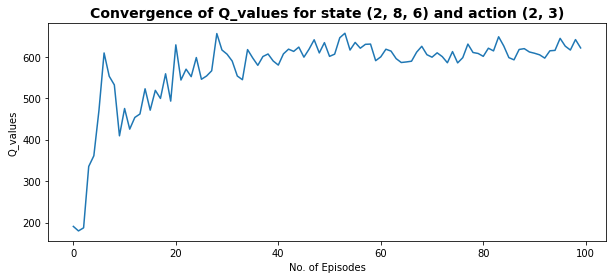

In [15]:
print("Tracking Convergence for state-action pair: State (2,8,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, 
                        state=(2,8,6), 
                        action=(2,3), 
                        states_tracked = agent.states_tracked)

#### From the graph we can observed that state (2,8,6) stabalizes as the agent plays more episodes.

- The fluctuations in the Q values have reduced with more number of episodes

## Epsilon decay function used for choosing an epsilon-greedy action during episode

In [18]:
time = np.arange(0,1000) ## In all 1000 episodes. 
epsilon_decay = 0.99
epsilon = 1

epsilon_decayed = []
epsilon_decayed.append(epsilon)

for i in time:
    new_epsilon = epsilon_decayed[i] * epsilon_decay
    epsilon_decayed.append(new_epsilon)

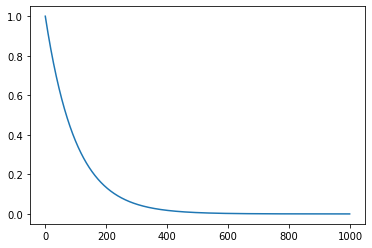

In [26]:
plt.plot(time, epsilon_decayed[:-1])
plt.show()